In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Reshape for CNN input (add channel dimension)
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255.0
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255.0

# Convert labels to one-hot encoding (optional, but common for CNNs with softmax)
# For sparse_categorical_crossentropy, this step is not strictly necessary if labels are integers.
# train_labels = tf.keras.utils.to_categorical(train_labels, 10)
# test_labels = tf.keras.utils.to_categorical(test_labels, 10)



In [6]:
# 1. Model Definition: Using a Convolutional Neural Network (CNN)
model = models.Sequential([
    # Optional: Data Augmentation layer (apply only during training)
    # layers.RandomRotation(factor=(-0.05, 0.05), input_shape=(28, 28, 1)),
    # layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    # layers.RandomZoom(height_factor=0.1),

    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    # Optional: Another conv layer, possibly with fewer filters
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.00005)), # Try larger dense layer with adjusted L2
    layers.Dropout(0.25), # Adjusted dropout rate

    layers.Dense(10, activation='softmax')
])




In [7]:
# 2. Compile the Model
# 2. Compile with potentially lower initial learning rate or AdamW
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005) # Slightly lower
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0008) # Requires tf-addons or TF 2.11+
# Or use SGD with Nesterov Momentum for fine-tuning
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 1, 1, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1, 1, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,826 (729.79 KB)

 Trainable params: 186,250 (727.54 KB)

 Non-trainable params: 576 (2.25 KB)

In [8]:
# 3. Train the Model
# 3. Callbacks with potentially more aggressive learning rate reduction
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, mode='max', verbose=1), # Increase patience
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001, verbose=1) # More aggressive reduction
]

history = model.fit(train_images, train_labels, epochs=100, # More epochs, relying on EarlyStopping
                    batch_size=64, # Try smaller batch size
                    validation_data=(test_images, test_labels),
                    callbacks=callbacks)

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)
print(f"\nTest accuracy: {test_acc:.4f}")




Epoch 1/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.9271 - loss: 0.2673 - val_accuracy: 0.9828 - val_loss: 0.0631 - learning_rate: 8.0000e-04
Epoch 2/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9861 - loss: 0.0498 - val_accuracy: 0.9862 - val_loss: 0.0477 - learning_rate: 8.0000e-04
Epoch 3/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9909 - loss: 0.0338 - val_accuracy: 0.9884 - val_loss: 0.0424 - learning_rate: 8.0000e-04
Epoch 4/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9931 - loss: 0.0258 - val_accuracy: 0.9907 - val_loss: 0.0346 - learning_rate: 8.0000e-04
Epoch 5/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9952 - loss: 0.0214 - val_accuracy: 0.9913 - val_loss: 0.0348 - learning_rate: 8.0000e-04
Epoch 6/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9959 - loss: 0.0185 - val_accuracy: 0.9932 - val_loss: 0.0291 - learning_rate: 8.0000e-04
Epoch 7/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - 

In [9]:
# 4. Evaluate the Model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"\nTest accuracy: {test_acc:.4f}")


313/313 - 1s - 2ms/step - accuracy: 0.9953 - loss: 0.0198

Test accuracy: 0.9953


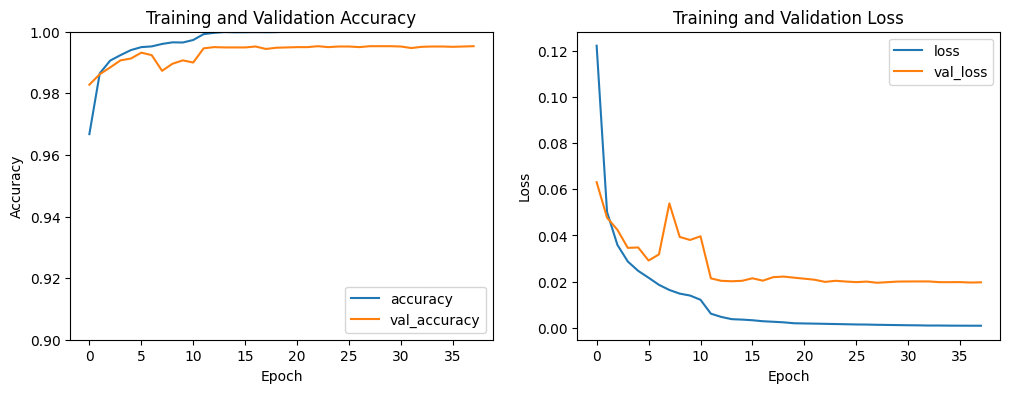

In [10]:

# 5. Plotting Training History (for analysis)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()